In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import datetime

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import gradio as gr

2025-07-21 14:22:15.386109: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753107735.543117      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753107735.586896      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1. Persiapan Dataset

In [2]:
dataset_path = '/kaggle/input/face-expression-recognition-dataset/images'

train_dir = os.path.join(dataset_path, 'train')
validation_dir = os.path.join(dataset_path, 'validation')

if not os.path.exists(train_dir):
    print(f"Error: Direktori pelatihan tidak ditemukan di {train_dir}")
    print("Pastikan Anda telah menambahkan dataset ke notebook Kaggle Anda dan pathnya benar.")
    exit()

img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    classes=['happy', 'sad']
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    classes=['happy', 'sad']
)

print(f"Jumlah sampel training: {train_generator.samples}")
print(f"Jumlah sampel validasi: {validation_generator.samples}")
print(f"Indeks kelas: {train_generator.class_indices}")

Found 12102 images belonging to 2 classes.
Found 2964 images belonging to 2 classes.
Jumlah sampel training: 12102
Jumlah sampel validasi: 2964
Indeks kelas: {'happy': 0, 'sad': 1}


# 2. Membangun Model dengan Transfer Learning

In [3]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

I0000 00:00:1753107770.067904      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# 3. Pelatihan Model

In [4]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

epochs = 40

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40


I0000 00:00:1753107782.876676     130 service.cc:148] XLA service 0x7aa798141080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753107782.877278     130 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753107783.770844     130 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/379 ━━━━━━━━━━━━━━━━━━━━ 1:16:23 12s/step - accuracy: 0.5312 - loss: 0.7277

I0000 00:00:1753107787.172122     130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


379/379 ━━━━━━━━━━━━━━━━━━━━ 255s 642ms/step - accuracy: 0.6463 - loss: 0.6290 - val_accuracy: 0.7348 - val_loss: 0.5289 - learning_rate: 1.0000e-04
Epoch 2/40
379/379 ━━━━━━━━━━━━━━━━━━━━ 137s 360ms/step - accuracy: 0.7156 - loss: 0.5588 - val_accuracy: 0.7503 - val_loss: 0.5061 - learning_rate: 1.0000e-04
Epoch 3/40
379/379 ━━━━━━━━━━━━━━━━━━━━ 136s 359ms/step - accuracy: 0.7285 - loss: 0.5395 - val_accuracy: 0.7621 - val_loss: 0.4884 - learning_rate: 1.0000e-04
Epoch 4/40
379/379 ━━━━━━━━━━━━━━━━━━━━ 138s 363ms/step - accuracy: 0.7376 - loss: 0.5288 - val_accuracy: 0.7733 - val_loss: 0.4782 - learning_rate: 1.0000e-04
Epoch 5/40
379/379 ━━━━━━━━━━━━━━━━━━━━ 137s 361ms/step - accuracy: 0.7451 - loss: 0.5129 - val_accuracy: 0.7524 - val_loss: 0.4959 - learning_rate: 1.0000e-04
Epoch 6/40
379/379 ━━━━━━━━━━━━━━━━━━━━ 140s 368ms/step - accuracy: 0.7413 - loss: 0.5155 - val_accuracy: 0.7756 - val_loss: 0.4668 - learning_rate: 1.0000e-04
Epoch 7/40
379/379 ━━━━━━━━━━━━━━━━━━━━ 139s 366ms/

# 4. Evaluasi Model

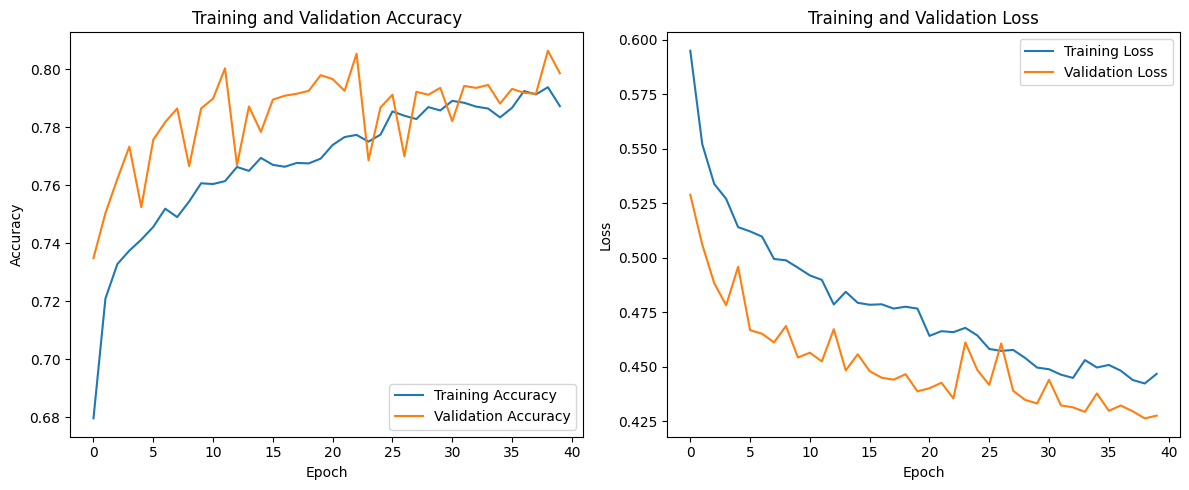

93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8064 - loss: 0.4301
Loss pada data validasi: 0.4264
Akurasi pada data validasi: 0.8063


In [5]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

loss, accuracy = model.evaluate(validation_generator)
print(f"Loss pada data validasi: {loss:.4f}")
print(f"Akurasi pada data validasi: {accuracy:.4f}")

# 5. Penyimpanan Data Baru

In [6]:
SAVE_DIR = "/kaggle/working/new_predictions_data"
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(os.path.join(SAVE_DIR, 'happy_predicted'), exist_ok=True)
os.makedirs(os.path.join(SAVE_DIR, 'sad_predicted'), exist_ok=True)

# 5. Implementasi UI dengan Gradio

In [7]:
def classify_and_save_face_expression(image_np: np.ndarray) -> str:
    """
    Fungsi untuk mengklasifikasikan ekspresi wajah dari gambar NumPy array,
    dan menyimpan gambar beserta prediksinya.
    """
    if image_np.shape[-1] == 4:
        image_np = image_np[:, :, :3]

    img_pil = Image.fromarray(image_np.astype(np.uint8))
    img_pil_resized = img_pil.resize((img_width, img_height))

    img_array = np.array(img_pil_resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction_raw = model.predict(img_array)[0][0]

    class_indices = train_generator.class_indices
    inverse_class_indices = {v: k for k, v in class_indices.items()}

    if prediction_raw >= 0.5: 
        predicted_class_name = inverse_class_indices[0] 
        confidence = prediction_raw 
    else: 
        predicted_class_name = inverse_class_indices[1] 
        confidence = 1 - prediction_raw 

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{predicted_class_name}_{confidence*100:.2f}_{timestamp}.jpg"

    save_path = os.path.join(SAVE_DIR, f"{predicted_class_name}_predicted", filename)
    img_pil.save(save_path)

    print(f"Gambar disimpan ke: {save_path}")

    return f"Prediksi: {predicted_class_name.capitalize()} (Kepercayaan: {confidence*100:.2f}%)"

sample_images_for_gradio = []
try:
    happy_sample_path = os.path.join(validation_dir, 'happy', os.listdir(os.path.join(validation_dir, 'happy'))[0])
    sad_sample_path = os.path.join(validation_dir, 'sad', os.listdir(os.path.join(validation_dir, 'sad'))[0])
    if os.path.exists(happy_sample_path):
        sample_images_for_gradio.append(happy_sample_path)
    if os.path.exists(sad_sample_path):
        sample_images_for_gradio.append(sad_sample_path)
except IndexError:
    print("Tidak cukup gambar sampel di direktori validasi untuk contoh Gradio.")

iface = gr.Interface(
    fn=classify_and_save_face_expression,
    inputs=gr.Image(type="numpy", label="Unggah Gambar Wajah"),
    outputs=gr.Textbox(label="Hasil Klasifikasi"),
    title="Klasifikasi Ekspresi Wajah: Happy vs Sad (dengan Penyimpanan Data)",
    description="Unggah gambar wajah untuk memprediksi ekspresi. "
                "Gambar yang diunggah akan disimpan untuk potensi pelatihan model di masa depan.",
    examples=[[path] for path in sample_images_for_gradio],
    allow_flagging="never"
)

iface.launch(share=True)

/usr/local/lib/python3.11/dist-packages/gradio/interface.py:416: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://e359b1fb44c40e4b46.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
